# AM216 Mini-Project: Drug target interaction and COVID-19

Rapid determination of whether a candidate small molecule will bind to a particular target receptor protein remains a stumbling block in drug discovery.  If you can find a small molecule that binds to a relevant protein and modifies its function, this molecule can serve as a drug.   This is an **inverse problem**: Given a protein, please find a small molecule that can bind to it.  

One way of solving this inverse problem would be to use molecular dynamics: Create a molecular model of a protein. Create a molecular model of all possible small molecule drugs that can bind to the protein. Simulate the interactions between the small molecules and the proteins. Find the molecules that work.

Or-you might be more mathematical and try to solve this as a straight-up optimization problem: Find the small molecule that optimally binds to the binding pocket of a given drug.

Although conceptually appealing, this methodology is impossible: The major bottleneck is that we do not know and cannot accurately represent the interactions between small molecules and proteins.  The potentials are empirical with fitting parameters--they cannot be found from first principles and despite decades of work, we simply do not have good representations for them. For that reason, physical computation has been of limited utility for drug discovery.  

We should mention that a secondary bottleneck is the computing power that would be required for this search -- but this is something that could be likely sorted out if it weren't for the first bottleneck.

An alternative approach is to use a *data driven approach*. Instead of representing the physics, lets make a list of all known proteins and all small molecules that binds to each protein.  Lets then design a data driven way of associating small molecules to proteins, representing binding.  

Note that for a data driven approach to succeed, the key step is to **find ways of representing the small molecule and the protein that make it possible to find the patterns in the existing datasets.**   Representation is the key problem.  Presumably, the best way to represent the proteins and the small molecules is to use the physics and biochemistry of what happens when binding occurs -- as by doing this, we will focus on features that are relevant.  Finding the right feature representations for this type of problem is a very active area of research.

In this miniproject, you will dip your toe into the pond by studying a canonical problem, the binding affinity of small molecules against target proteins.  

Given all that is happening in the world right now, it seems appropriate to assign you the additional mission is to use the trained model to identify drugs that could bind to the main protease$^*$ protein of COVID-19 and prevent the production of viral enzyme. 

To help you in this mission, you are given KIBA ("Kinase Inhibitor Bioassay") dataset which contains 2111 drugs and 229 proteins with total of 118254 drug-protein binding affinity scores. Those are stored in `ligands_can.txt`, `proteins.txt`, and `Y`, respectively. The rows of `Y` index drugs and the columns index proteins. The element of `Y` is a real-valued binding score that takes into account dissociation constant $K_d$, inhibition constant $K_i$, and half maximal inhibitory concentration $IC_{50}$. Refer to [original paper](https://pubs.acs.org/doi/pdf/10.1021/ci400709d) for more detail. We also provide splitted indices for 5-fold cross validation in `train_fold_setting.txt` and testset indices in `test_fold_setting.txt`. Lastly, `6Y84_A.fasta.txt` contains the amino acid sequence of COVID-19 protease.

You will evalulate the performance of your model using MSE and Corcordance Index (CI), which is slightly relaxed metric that measures whether the predicted binding affinity val- ues of two random drug–target pairs were predicted in the same order as their true values were.

*: Note that there are many other drug targets for COVID-19 virus. [This page](
https://www.guidetopharmacology.org/coronavirus.jsp) gives you a good summary. 

To help you get started, we will first introduce you to Rdkit and DeepChem packages.

## 1. Basic Cheminformatics with Rdkit and DeepChem

For this project, you will most likely heavily rely on Rdkit and Deepchem. You can install DeepChem along with Rdkit following instruction [here](https://deepchem.io). If you are using Colab, run the following code block.


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# This may take a few minutes to run!
!wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
!chmod +x Anaconda3-2019.10-Linux-x86_64.sh
!bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

--2021-04-26 02:09:33--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   162MB/s    in 3.1s    

2021-04-26 02:09:37 (162 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.7=py37

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Developing new medicine is a very time-consuming, labor-intensive, and expensive task which begins with rounds of screening process where researchers run some assays with thousands of molecules to identify potential drug candidates to go onto a clinical trial. The field of cheminformatics have been developed to help accelerate this process by performing laboratory experiments on computers. 

In order to this we need to find a way to represent a molecule so that we can train machine learning models on it.  As mentioned above, this is a critical step.   If we were doing physics we would want to represent the molecule in the most natural way to represent the physics. For example there are features of the molecules that *cause* it to bind to the protein in question -- there are specific interactions between the chemical groups of the molecule and the amino acids. From a physical perspective, identifying these features is the most important part of the problem and we would like the representation to emphasize these.

But given that we don't have any idea what is happening, we need another approach. We somehow have to represent both molecules and proteins in a way so that we can train machine learning models on them to see if it is possible to associate them with each other.

For small molecules, this is a classic problem. How do we take a molecule and represent it. There is a field that has addressed this called 'cheminformatics'.  

A particularly simple method is for molecules are represented as text strings called SMILES (“Simplified Molecular-Input Line-Entry System”). Please refer to [this page](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html) for more explanantion. Here is an example SMILES string and the molecule it represents, which we obtain via `MolFromSmiles` function of Rdkit.

In [ ]:
import numpy as np
import rdkit
from rdkit.Chem import Draw
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import MolFromSmiles

import tensorflow as tf
from keras import Sequential, Model
from keras.layers import Dense, concatenate, Dropout
import pandas as pd

Using TensorFlow backend.


SMILES string:
O[C@@H](CNC1CCN(CC1)c2ccc(CC3SC(=O)NC3=O)cc2)c4ccc(O)c(NS(=O)(=O)c5ccccc5)c4

Original molecule:


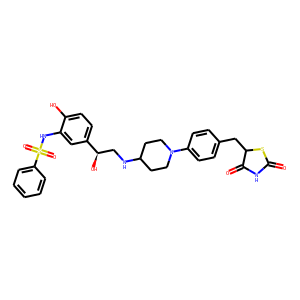

In [ ]:
smiles = []
LOCAL_PATH = '../Drug Binding'
G_PATH = './drive/MyDrive/Colab Notebooks/Drug Binding'
with open(G_PATH + '/data_Drug_target_binding_affinity/Sample_Ligand_List.txt', 'r') as f:
    for line in f:
        smiles.append(line[:-1])
        
print('SMILES string:')
print(smiles[0])

print('\nOriginal molecule:')
mols = MolFromSmiles(smiles[0])
Draw.MolToImage(mols)

As you may have guessed, this SMILES string does not contain much of structural and chemical information present in the actual molecule representation. 

The smiles string is a string of symbols -- it is very different from the binding structure of the molecules.  One option that we have is to train machine learning models on the smiles strings directly.

This has been found to not be the most effective way of proceeding. Another approach that people have thought of is to convert this to a "chemical fingerprint". This is a
 vector of 1's and 0's that captures the presence or absence of specific features, as determined by local arrangement of atoms in a molecule.  


There are many algorithms that give you this finger print. One example is Extended-connectivity fingerprints (ECFP) scheme, which comes as `GetMorganFingerprintAsBitVec` in Rdkit. Here is an example of ECFP4. The number at the end refers to bond distances used for featurizing.

In [ ]:
print('ECFP4')
molecule = MolFromSmiles(smiles[0])
ECFP2 = Chem.GetMorganFingerprintAsBitVect(molecule, 2).ToBitString()
ECFP2arr = np.array(list(map(int, ECFP2)))
print(ECFP2arr[:20], '...')
print(ECFP2arr.shape)

ECFP4
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
(2048,)


Lots of Rdkit's featurization algorithms are ported in DeepChem. This is a deep learning for chemistry toolkit that was developed at Stanford.

We can list the descriptors for molecules from RDKIT. Note that in addition to fingerprints, there are all sorts of purely chemical features, such as


*   Number of Hydrogen acceptors
*   Number of aromatic rings
*   Number of radical electrons
*   Number of rings in the molecule
*   Partial charges


And so forth.  When you are doing machine learning with complete ignorance of why the small molecule binds to something, you might as well be as general as you can be!!



In [ ]:
from deepchem.feat import RDKitDescriptors   

for descriptor in RDKitDescriptors.allowedDescriptors:
    print(descriptor)


MolLogP
SMR_VSA3
SlogP_VSA2
Chi1v
VSA_EState3
NumHeteroatoms
PEOE_VSA1
EState_VSA3
MinAbsPartialCharge
ExactMolWt
SlogP_VSA6
VSA_EState8
NumHAcceptors
Chi2n
MinEStateIndex
NumAromaticRings
LabuteASA
PEOE_VSA5
NumAliphaticHeterocycles
PEOE_VSA4
PEOE_VSA3
NumHDonors
PEOE_VSA13
Kappa1
NumSaturatedHeterocycles
Chi3v
SMR_VSA4
MaxEStateIndex
EState_VSA10
SMR_VSA1
SlogP_VSA11
SlogP_VSA7
VSA_EState2
SMR_VSA6
VSA_EState1
SMR_VSA9
PEOE_VSA12
EState_VSA5
MinPartialCharge
SMR_VSA7
SlogP_VSA1
HallKierAlpha
TPSA
RingCount
PEOE_VSA14
VSA_EState10
HeavyAtomMolWt
Kappa2
NOCount
EState_VSA4
Chi4v
NumSaturatedRings
PEOE_VSA2
MaxAbsEStateIndex
Chi2v
PEOE_VSA6
Chi4n
MaxAbsPartialCharge
SlogP_VSA5
NHOHCount
BertzCT
MinAbsEStateIndex
SMR_VSA10
SlogP_VSA4
Chi1n
PEOE_VSA7
EState_VSA2
VSA_EState4
Chi0v
NumValenceElectrons
NumAliphaticCarbocycles
Kappa3
Chi0n
VSA_EState6
PEOE_VSA8
EState_VSA6
NumRotatableBonds
VSA_EState9
SlogP_VSA9
VSA_EState5
Chi1
PEOE_VSA9
SMR_VSA5
EState_VSA7
EState_VSA8
NumAromaticCarbocycl

Deepchem has also implemented a large number of different machine learning models to build models on top of these features. We can list this as follows:

In [ ]:
dir(dc.models)

['ANIRegression',
 'AtomicConvModel',
 'BPSymmetryFunctionRegression',
 'ChemCeption',
 'DAGModel',
 'DAGTensorGraph',
 'DTNNModel',
 'DTNNTensorGraph',
 'GAN',
 'GraphConvModel',
 'GraphConvTensorGraph',
 'IRV',
 'KerasModel',
 'MPNNModel',
 'MPNNTensorGraph',
 'Model',
 'MultitaskClassifier',
 'MultitaskFitTransformRegressor',
 'MultitaskRegressor',
 'OntologyModel',
 'OntologyNode',
 'ProgressiveMultitaskClassifier',
 'ProgressiveMultitaskRegressor',
 'RobustMultitaskClassifier',
 'RobustMultitaskRegressor',
 'ScScoreModel',
 'SeqToSeq',
 'SequenceDNN',
 'Sequential',
 'SingletaskToMultitask',
 'SklearnModel',
 'Smiles2Vec',
 'TensorGraph',
 'TensorflowMultitaskIRVClassifier',
 'TextCNNModel',
 'TextCNNTensorGraph',
 'ValidationCallback',
 'WGAN',
 'WeaveModel',
 'WeaveTensorGraph',
 'XGBoostModel',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'atomic_conv',
 'callbacks',
 'chemnet_models',
 'create_g

## 2. Parsing KIBA dataset

Now we are ready to examine the Kinase dataset.  The way this works is that we are given a particular protein, and for that protein, we want to predict the small molecules that bind to it. Different proteins of course have different sets of small molecules.  This dataset contains a large set of proteins, and for each of them, it contains the small molecules that bind.

To associate proteins with small molecules, we also need a representation of the proteins. Proteins are of course sequences of amino acids, so the representation is just a string of amino acids.   To use the string of amino acids with numbers. We do this by simply mapping each amino acid (represented by a letter) to a number.

In [ ]:
import matplotlib.pyplot as plt
import json
import pickle
from collections import OrderedDict
import networkx as nx

In [ ]:
# for converting protein sequence to categorical format/numerical format
seq_voc = "ABCDEFGHIKLMNOPQRSTUVWXYZ"
seq_dict = {v:i for i,v in enumerate(seq_voc)}
seq_dict_len = len(seq_dict)
max_seq_len = 1000   # Note that all protein data will have the same length 1000 

def seq_to_cat(prot):  # prot: protein
    x = np.zeros(max_seq_len)
    for i, ch in enumerate(prot[:max_seq_len]): 
        x[i] = seq_dict[ch]
    return x  

# for Concordance index evaluation
def ci(y,f):
    ind = np.argsort(y)  # np.argsort Returns the indices that would sort an array.
    y = y[ind]
    f = f[ind]
    i = len(y)-1
    j = i-1
    z = 0.0
    S = 0.0
    while i > 0:
        while j >= 0:
            if y[i] > y[j]:
                z = z+1
                u = f[i] - f[j]
                if u > 0:
                    S = S + 1
                elif u == 0:
                    S = S + 0.5
            j = j - 1
        i = i - 1
        j = i - 1
    ci = S/z
    return ci if z != 0 else 0

We read in the ligands and the proteins, as well as the binding data.

In [ ]:
fpath = G_PATH + '/data_Drug_target_binding_affinity/data/kiba/'
# fpath = LOCAL_PATH + '/data_Drug_target_binding_affinity/data/kiba/'

# Read in drugs and proteins
drugs_ = json.load(open(fpath + "ligands_can.txt"), object_pairs_hook=OrderedDict)
drugs = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(d),isomericSmiles=True) for d in drugs_.values()])
proteins_ = json.load(open(fpath + "proteins.txt"), object_pairs_hook=OrderedDict)
proteins = np.array(list(proteins_.values()))

# Read in affinity data
affinity = np.array(pickle.load(open(fpath + "Y","rb"), encoding='latin1'))

# Read in train/test fold  
train_fold = json.load(open(fpath + "folds/train_fold_setting1.txt"))
train_fold = [ee for e in train_fold for ee in e ]    
'''
Here all validation folds are aggregated into training set. 
If you want to train models with different architectures and/or 
optimize for model hyperparameters, we encourage you to use 5-fold 
cross validation as provided here.
'''
test_fold = json.load(open(fpath + "folds/test_fold_setting1.txt"))

# Prepare train/test data with fold indices
rows, cols = np.where(np.isnan(affinity)==False) 
drugs_tr = drugs[rows[train_fold]]    # (98545,)
proteins_tr = np.array([seq_to_cat(p) for p in proteins[cols[train_fold]]])   # (98545, 1000)
affinity_tr = affinity[rows[train_fold], cols[train_fold]]  # (98545,)

drugs_ts = drugs[rows[test_fold]] # (19709,)
proteins_ts = np.array([seq_to_cat(p) for p in proteins[cols[test_fold]]]) # (19709, 1000)
affinity_ts = affinity[rows[test_fold], cols[test_fold]]    # (19709,)

In [ ]:
print('Example of drug:{}'.format(drugs_tr[0]))
print('Example of protein:{} ...'.format(proteins_tr[0][:10]))
print('Example of affinity score:{}'.format(affinity_tr[0]))

Example of drug:O=C1c2c(c3c4ccc(O)cc4n(C4OC(CO)C(O)C(O)C4O)c3c3[nH]c4cc(O)ccc4c23)C(=O)N1NC(CO)CO
Example of protein:[11. 17.  0. 12. 12. 17. 14. 14. 17.  0.] ...
Example of affinity score:9.798970004000001


In [ ]:
# Convert to ECFP fingerprint
smileToMol = lambda x: MolFromSmiles(x)  # molecules from smiles
featurizer = dc.feat.CircularFingerprint(size=1024)

drugs_mol_tr = list(map(smileToMol, drugs_tr))
drugs_ecfp_tr = featurizer.featurize(drugs_mol_tr)
drugs_mol_ts = list(map(smileToMol, drugs_ts))
drugs_ecfp_ts = featurizer.featurize(drugs_mol_ts)

print(drugs_ecfp_tr.shape)
print(drugs_ecfp_ts.shape)

(98545, 1024)
(19709, 1024)


In [ ]:
tr_size, drug_size = drugs_ecfp_tr.shape[0], drugs_ecfp_tr.shape[1]
ts_size = drugs_ecfp_ts.shape[0]

protein_size = max_seq_len

## 3. Train a model on KIBA data


### 3.1 Baseline Model


#### (1) Model description:
Here we first try a naive baseline prediction model that comprises two blocks, each of which aims to learn representations from SMILES strings and protein sequences. For each we used a FC layer to learn the representation of input data, since Fully-Connected Neural Networks are popular models for baseline. The final features layers were concatenated and fed into three FC layers, which is the DeepDTA, adopted from the paper “DeepDTA: deep drug–target binding affinity prediction”. Specifically, we used 1024 nodes in the first two FC layers, each followed by a dropout layer of rate 0.1 to avoid over-fitting. And the third layer consisted of 512 nodes and was followed by the output layer. Below is the summary of the model architecture. We also used Adam as the optimizer and MSE as the loss function.


In [ ]:
# Have fun!
import tensorflow as tf
from keras import Sequential, Model
from keras.layers import Dense, concatenate, Dropout

def build_baseline_model(drug_size, protein_size):

  drug_model = Sequential()
  drug_model.add(Dense(1, input_shape=(drug_size,), activation='linear'))

  protein_model = Sequential()
  protein_model.add(Dense(1, input_shape=(protein_size,), activation='linear'))

  # concat_layer = tf.keras.layers.Concatenate([drug_model.outputs[0], protein_model.outputs[0]])
  model_concat = concatenate([drug_model.output, protein_model.output])
  # fully connected
  model_concat = Dense(1024, activation='relu')(model_concat)
  model_concat = Dropout(0.1)(model_concat)
  model_concat = Dense(1024, activation='relu')(model_concat)
  model_concat = Dropout(0.1)(model_concat)
  model_concat = Dense(512, activation='relu')(model_concat)
  model_concat = Dense(1, kernel_initializer='normal')(model_concat)
  
  model = Model(inputs=[drug_model.input, protein_model.input], outputs=model_concat)

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
  
  return model

model = build_baseline_model(drug_size=drug_size, protein_size=protein_size)
print(model.summary())

In [ ]:
from keras.callbacks import EarlyStopping

epochs = 100
batch_size = 50

callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

train_history = model.fit([drugs_ecfp_tr, proteins_tr], affinity_tr, 
                    validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=True)


Train on 78836 samples, validate on 19709 samples
Epoch 1/100
78836/78836 [==============================] - 68s 865us/step - loss: 0.5321 - mean_squared_error: 0.5321 - val_loss: 2.0868 - val_mean_squared_error: 2.0868
Epoch 2/100
78836/78836 [==============================] - 69s 873us/step - loss: 0.5283 - mean_squared_error: 0.5283 - val_loss: 2.1565 - val_mean_squared_error: 2.1565
Epoch 3/100
78836/78836 [==============================] - 67s 853us/step - loss: 0.5310 - mean_squared_error: 0.5310 - val_loss: 1.2997 - val_mean_squared_error: 1.2997
Epoch 4/100
78836/78836 [==============================] - 66s 838us/step - loss: 0.5190 - mean_squared_error: 0.5190 - val_loss: 1.6997 - val_mean_squared_error: 1.6997
Epoch 5/100
78836/78836 [==============================] - 67s 844us/step - loss: 0.5052 - mean_squared_error: 0.5052 - val_loss: 1.7902 - val_mean_squared_error: 1.7902
Epoch 6/100
78836/78836 [==============================] - 67s 855us/step - loss: 0.5030 - mean_squa

KeyboardInterrupt: ignored

In [ ]:

print("Evaluate on test data")
results = model.evaluate([drugs_ecfp_ts, proteins_ts], affinity_ts, batch_size=128)
print("test MSE loss is:", results)

Evaluate on test data
19709/19709 [==============================] - 2s 105us/step
test MSE loss is: [0.398003730737514, 0.3980037271976471]


In [ ]:
predicted_affinity = model.predict([drugs_ecfp_ts, proteins_ts])

In [ ]:
ci_score = ci(affinity_ts, predicted_affinity)
print('test CI score is:', ci_score)

test CI score is: 0.7536044611424282


#### (2) Result:
Training the model for 10 epochs, we tested the trained model on the test dataset. The model achieves the MSE of 0.398 and CI score of 0.754, which is slightly lower than the model presented in the original paper. 


### 3.2 Train a CNN model on KIBA Data
Drugs and protein are represented by 1-D vectors, which represent their structures in the numerical way. Whether a drug-protein binding has a high affinity score depends on whether the drug and protein have matching structures, especially the geometrical structures. CNN is a good method to identify geometrical shapes, thus we can use it to extract the geometrical characterstics of drugs and proteins, and predict the affinity score. To match the dimensions of drug and proteins vectors, we use 1D CNN here.

The idea of CNN model is also from the paper "DeepDTA: deep drug–target binding affinity prediction"(https://academic.oup.com/bioinformatics/article/34/17/i821/5093245). For the structure of the CNN model, since drugs and proteins are two different inputs, it doesn't make sense to concatenate them together and use the concatenation as an input. So we use two CNN models ```drug_cnn``` and ```prot_cnn``` to take drugs and proteins as inputs respectively, and concatenate the outputs of these 2 CNN models to a new embedding, which is the input to the third CNN model ```cnn_concat```, then get the final CNN model ```cnn```. We also used the dropout layer to avoid overfitting and the dense layer to get the final result.

The implementation and evaluation of the CNN model is as below.

In [ ]:
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten

#### (1) Prepare data for CNN

In [ ]:

num_train, num_drugs = drugs_ecfp_tr.shape
num_prot = proteins_tr.shape[1]
drugs_tr_reshape = drugs_ecfp_tr.reshape((num_train, num_drugs, 1))
proteins_tr_reshape = proteins_tr.reshape((num_train, num_prot, 1))

# Testing data
drug_ts_reshape = drugs_ecfp_ts.reshape((drugs_ecfp_ts.shape[0], drugs_ecfp_ts.shape[1], 1))
proteins_ts_reshape = proteins_ts.reshape((proteins_ts.shape[0], proteins_ts.shape[1], 1))

#### (2) Build and Train a CNN model

In [ ]:
# CNN 
from keras import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten

def sub_cnn(input_dim):
    cnn = Sequential() # Create sequential model
    cnn.add(Conv1D(16, 3, activation='relu', input_shape=(input_dim, 1)))
    cnn.add(MaxPooling1D(3))
    cnn.add(Flatten())
    cnn.add(Dropout(0.1))
    cnn.add(Dense(16, activation = 'linear'))
    return cnn
drug_cnn = sub_cnn(num_drugs)
prot_cnn = sub_cnn(num_prot)
cnn_concat = concatenate([drug_cnn.output, prot_cnn.output])

'''
cnn_drug = Sequential() # Create sequential model
cnn_drug.add(Conv1D(16, 3, activation='relu', input_shape=(num_drugs, 1)))
cnn.add(MaxPooling1D(3))

cnn_prot = Sequential()
cnn_prot.add(Conv1D(16, 3, activation='relu', input_shape=(num_prot, 1)))
cnn.add(MaxPooling1D(3))
# Concatenate
cnn = concatenate([cnn_drug.output, cnn_prot.output])
'''

cnn_concat = Dense(1024, activation='relu')(cnn_concat)
cnn_concat = Dropout(0.1)(cnn_concat)
cnn_concat = Dense(16, activation='relu')(cnn_concat)

cnn_concat = Dense(1, activation='linear')(cnn_concat)

cnn = Model(inputs=[drug_cnn.input, prot_cnn.input], outputs=cnn_concat)
# Show model summary
cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_3_input (InputLayer)     (None, 1024, 1)      0                                            
__________________________________________________________________________________________________
conv1d_4_input (InputLayer)     (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 1022, 16)     64          conv1d_3_input[0][0]             
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 998, 16)      64          conv1d_4_input[0][0]             
____________________________________________________________________________________________

In [ ]:
from keras.callbacks import EarlyStopping

epochs = 100
batch_size = 256

callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
train_history = cnn.fit([drugs_tr_reshape, proteins_tr_reshape], affinity_tr, 
                    validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=True)


Train on 78836 samples, validate on 19709 samples
Epoch 1/100
78836/78836 [==============================] - 66s 834us/step - loss: 2.6518 - mean_squared_error: 2.6518 - val_loss: 0.4968 - val_mean_squared_error: 0.4968
Epoch 2/100
78836/78836 [==============================] - 65s 821us/step - loss: 0.6922 - mean_squared_error: 0.6922 - val_loss: 0.5036 - val_mean_squared_error: 0.5036
Epoch 3/100
78836/78836 [==============================] - 64s 818us/step - loss: 0.6023 - mean_squared_error: 0.6023 - val_loss: 0.4733 - val_mean_squared_error: 0.4733
Epoch 4/100
78836/78836 [==============================] - 64s 815us/step - loss: 0.5789 - mean_squared_error: 0.5789 - val_loss: 0.4322 - val_mean_squared_error: 0.4322
Epoch 5/100
78836/78836 [==============================] - 64s 812us/step - loss: 0.5364 - mean_squared_error: 0.5364 - val_loss: 0.4204 - val_mean_squared_error: 0.4204
Epoch 6/100
78836/78836 [==============================] - 64s 813us/step - loss: 0.5053 - mean_squ

#### (3) Evaluate the CNN model

In [ ]:
drug_ts_reshape = drugs_ecfp_ts.reshape((drugs_ecfp_ts.shape[0], drugs_ecfp_ts.shape[1], 1))
proteins_ts_reshape = proteins_ts.reshape((proteins_ts.shape[0], proteins_ts.shape[1], 1))
print("Evaluate on test data")
results = cnn.evaluate([drug_ts_reshape, proteins_ts_reshape], affinity_ts, batch_size=128)
print("test MSE loss is:", results)

Evaluate on test data
19709/19709 [==============================] - 6s 301us/step
test MSE loss is: [0.21053694547722707, 0.21053697168827057]


In [ ]:
predicted_affinity = cnn.predict([drug_ts_reshape, proteins_ts_reshape])
ci_score = ci(affinity_ts, predicted_affinity)
print('test CI score is:', ci_score)

test CI score is: 0.8394054274277895


[The original paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4364066/) obtained CI score of 0.782 and MSE of 0.411, and [random forest model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5395521/) got 0.836 and 0.222. Can you beat them?

The CNN models has MSE = 0.21053694547722707, and CI score = 0.8394054274277895 on the test set. 
Both the MSE value and the CI score of the CNN model beat the above baseline model, the original paper, and the random forest model. It's possibly because that CNN models can extract the underlying characteristics of drugs and proteins better than the Kronecker RLS method used in the original paper. 

The performance is just a little better than that of the random forest model, but we haven't use the cross validation which was used in the paper for model selection. Let's use cross validation and see if it would improve the performance.


#### (4) Cross Validation on CNN

Since a CNN model has so many parameters, it's hard to get the best value of each parameter by cross validation, but we can get the final prediction results by averaging the predicitons from each fold's model. Although some cross validation uses training data and testing data as a whole dataset for data splitting, here we do not touch testing data while training the models. We do 5-fold cross validation on the training data set, and do prediciton and model evaluation on the test data set. 

In the model training below, we do not set validation_split parameter, i.e. validation_split = 0. So the cross validaiton here is more like training data with 5 different validation sets, and the test indices from the ```kfold.split()``` function work as the validation indices.

In [ ]:
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
import os
import pickle

num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
epochs = 80
batch_size = 256

def sub_cnn(input_dim):
    cnn = Sequential() # Create sequential model
    cnn.add(Conv1D(16, 3, activation='relu', input_shape=(input_dim, 1)))
    cnn.add(MaxPooling1D(3))
    cnn.add(Flatten())
    cnn.add(Dropout(0.1))
    cnn.add(Dense(16, activation = 'linear'))
    return cnn

def cnn(i, x, y): 
  drug_cnn = sub_cnn(num_drugs)
  prot_cnn = sub_cnn(num_prot)
  cnn_concat = concatenate([drug_cnn.output, prot_cnn.output])
  cnn_concat = Dense(1024, activation='relu')(cnn_concat)
  cnn_concat = Dropout(0.1)(cnn_concat)
  cnn_concat = Dense(16, activation='relu')(cnn_concat)

  cnn_concat = Dense(1, activation='linear')(cnn_concat)

  cnn = Model(inputs=[drug_cnn.input, prot_cnn.input], outputs=cnn_concat)
  # Show model summary
  cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])


  callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  train_history = cnn.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=True)
  # save the trained model for later use
  
  save_folder = f'{G_PATH}/saved_models/'
  os.makedirs(save_folder, exist_ok=True)
  save_path = save_folder + 'cnn_model_fold_{}'.format(i)
  cnn.save(save_path)
  print('model_{} saved'.format(i))
  return cnn

i = 1
models = []
cv_mse = []
MSE = []
cis = []
for train, test in kfold.split(drugs_tr_reshape, affinity_tr):
  # Define the model architecture
  x = [drugs_tr_reshape[train], proteins_tr_reshape[train]]
  y = affinity_tr[train]
  model = cnn(i, x, y)
  
  scores = model.evaluate([drugs_tr_reshape[test], proteins_tr_reshape[test]], affinity_tr[test], verbose=0)
  cv_mse.append(scores[1])
  print("Evaluate on test data by model {}".format(i))
  results = model.evaluate([drug_ts_reshape, proteins_ts_reshape], affinity_ts, batch_size=128)
  MSE.append(results[1])
  print("test MSE loss is:", results)
  predicted_affinity = model.predict([drug_ts_reshape, proteins_ts_reshape])
  ci_score = ci(affinity_ts, predicted_affinity)
  print('test CI score is:', ci_score)
  cis.append(ci_score)
  i += 1

save_folder = f'{G_PATH}/saved_results/'
with open(save_folder + "cv_mse.txt", "wb") as f:
  pickle.dump(cv_mse, f)
with open(save_folder + 'MSE.txt', 'wb') as f:
  pickle.dump(MSE, f)
with open(save_folder + 'CI.txt', 'wb') as f:
  pickle.dump(cis, f)


Epoch 1/80
78836/78836 [==============================] - 35s 444us/step - loss: 2.4288 - mean_squared_error: 2.4288
Epoch 2/80
78836/78836 [==============================] - 34s 437us/step - loss: 0.6623 - mean_squared_error: 0.6623
Epoch 3/80
78836/78836 [==============================] - 35s 440us/step - loss: 0.5858 - mean_squared_error: 0.5858
Epoch 4/80
78836/78836 [==============================] - 34s 436us/step - loss: 0.5541 - mean_squared_error: 0.5541
Epoch 5/80
78836/78836 [==============================] - 35s 438us/step - loss: 0.5193 - mean_squared_error: 0.5193
Epoch 6/80
78836/78836 [==============================] - 34s 436us/step - loss: 0.4930 - mean_squared_error: 0.4930
Epoch 7/80
78836/78836 [==============================] - 34s 435us/step - loss: 0.4862 - mean_squared_error: 0.4862
Epoch 8/80
78836/78836 [==============================] - 35s 440us/step - loss: 0.4784 - mean_squared_error: 0.4784
Epoch 9/80
78836/78836 [==============================] - 35s 43

In [ ]:
import numpy as np
import pickle

save_folder = f'{G_PATH}/saved_results/'
with open(save_folder + "cv_mse.txt", "rb") as f:
  cv_mse = pickle.load(f)
with open(save_folder + "MSE.txt", "rb") as f:
  MSE = pickle.load(f)
with open(save_folder + "CI.txt", "rb") as f:
  cis = pickle.load(f)
print("test MSE loss is:", np.mean(MSE))
print('test CI score is:', np.mean(cis))

test MSE loss is: 0.21358680427074433
test CI score is: 0.8337713494290373


#### (5) Result
The CNN model with cross validation gives almost same MSE and CI score on the test set as the original CNN model. The reason may be that CNN already extracts the characteristics of drugs and proteins very well, so there is not much improvement that cross validation can do. 

Considering that cross validation takes long training time, we recommend using CNN model without cross validation in practice. 

## 4. Use  your model on COVID-19 protease

Now, use your trained model to identify drugs that could be used as COVID-19 protease inhibitors from these 2111 drugs in the dataset. The sequence of the protease is provided in `6Y84_A.fasta.txt`. You might want to first predict a binding affinity of Ritonavior, a well known HIV drug that binds to HIV protease, to get the sense of a good binding score for this task. SMILES of Ritonavior is provided below.  

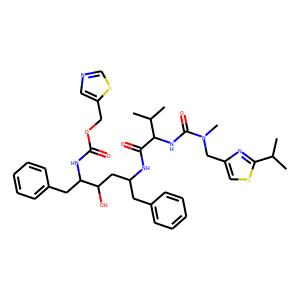

In [ ]:
ritonavior = 'CC(C)C1=NC(=CS1)CN(C)C(=O)NC(C(C)C)C(=O)NC(CC2=CC=CC=C2)CC(C(CC3=CC=CC=C3)NC(=O)OCC4=CN=CS4)O'
rit_mol = MolFromSmiles(ritonavior)
Draw.MolToImage(rit_mol)

In [ ]:
rit = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(ritonavior),isomericSmiles=True)])
rit

array(['CC(C)c1nc(CN(C)C(=O)NC(C(=O)NC(Cc2ccccc2)CC(O)C(Cc2ccccc2)NC(=O)OCc2cncs2)C(C)C)cs1'],
      dtype='<U83')

Please keep in mind that proteins in KIBA data are kinase family, a different kind from protease. So in this exercise, we are relying on transfer learning. That is, the learned embedding for predicting kinase could be useful for predicting protease binding as well.

In [ ]:
protease = "SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ"
protease_tr = np.array([seq_to_cat(protease)])
protease_tr

array([[17.,  6.,  5., 16.,  9., 11.,  0.,  5., 14., 17.,  6.,  9., 20.,
         4.,  6.,  2., 11., 20., 15., 20., 18.,  2.,  6., 18., 18., 18.,
        10., 12.,  6., 10., 21., 10.,  3.,  3., 20., 20., 23.,  2., 14.,
        16.,  7., 20.,  8.,  2., 18., 17.,  4.,  3., 11., 10., 12., 14.,
        12., 23.,  4.,  3., 10., 10.,  8., 16.,  9., 17., 12.,  7., 12.,
         5., 10., 20., 15.,  0.,  6., 12., 20., 15., 10., 16., 20.,  8.,
         6.,  7., 17., 11., 15., 12.,  2., 20., 10.,  9., 10.,  9., 20.,
         3., 18.,  0., 12., 14.,  9., 18., 14.,  9., 23.,  9.,  5., 20.,
        16.,  8., 15., 14.,  6., 15., 18.,  5., 17., 20., 10.,  0.,  2.,
        23., 12.,  6., 17., 14., 17.,  6., 20., 23., 15.,  2.,  0., 11.,
        16., 14., 12.,  5., 18.,  8.,  9.,  6., 17.,  5., 10., 12.,  6.,
        17.,  2.,  6., 17., 20.,  6.,  5., 12.,  8.,  3., 23.,  3.,  2.,
        20., 17.,  5.,  2., 23., 11.,  7.,  7., 11.,  4., 10., 14., 18.,
         6., 20.,  7.,  0.,  6., 18.,  3., 10.,  4.

In [ ]:
smileToMol = lambda x: MolFromSmiles(x)
featurizer = dc.feat.CircularFingerprint(size=1024)

rit_mol = list(map(smileToMol, rit))
rit_ecfp = featurizer.featurize(rit_mol)

print(rit_ecfp.shape, protease_tr.shape)

(1, 1024) (1, 1000)


### Prediction by the baseline model



In [ ]:
path = './drive/MyDrive/Colab Notebooks/data_Drug_target_binding_affinity/baseline_model'
model = tf.keras.models.load_model(path)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# Have fun!
for layer in model.layers[:5]:
  layer.trainable = "False"

model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_113_input (InputLayer)    [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense_114_input (InputLayer)    [(None, 1000)]       0                                            
__________________________________________________________________________________________________
dense_113 (Dense)               (None, 1)            1025        dense_113_input[0][0]            
__________________________________________________________________________________________________
dense_114 (Dense)               (None, 1)            1001        dense_114_input[0][0]            
___________________________________________________________________________________________

In [ ]:
target = model.predict([rit_ecfp, protease_tr])[0][0]
print(target)

11.488001


In [ ]:
pred_drug = ritonavior
smileToMol = lambda x: MolFromSmiles(x)
featurizer = dc.feat.CircularFingerprint(size=1024)
for drug in drugs:
  drug_smiles = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(drug),isomericSmiles=True)])
  drug_mol = list(map(smileToMol, drug_smiles))
  drug_ecfp = featurizer.featurize(drug_mol)
  score = model.predict([drug_ecfp, protease_tr])[0][0]
  if score>target:
    print(drug, score)
    target = score
    pred_drug = drug
print(pred_drug, target)

O=C(Cc1ccccc1)Nc1cccc(-c2nc3sccn3c2-c2ccnc(Nc3cccc(N4CCOCC4)c3)n2)c1 11.586634
CNc1cncc(-c2c[nH]c(=O)c(NC(=O)c3ccc(N4CCCC4CN4CCCC4)cc3)c2)n1 11.786759
CN(c1ncccc1CNc1nc(Nc2ccc3c(c2)CC(=O)N3)ncc1C(F)(F)F)S(C)(=O)=O 12.052496
COc1cc(Nc2ncc([N+](=O)[O-])c(Nc3ccccc3C(N)=O)n2)cc(OC)c1OC 12.538106
CN(C)C1CCCC(Nc2nc(Cl)cc(-c3c[nH]c4ncccc34)n2)C1 12.572794
FC(F)(F)c1cccc(CNc2cc(-c3c[nH]c4ncccc34)ncn2)c1 12.776003
Clc1cc(-c2c[nH]c3ncccc23)nc(NC2CCOCC2)n1 12.80786
Cn1cc(Nc2ncc(Cl)c(Nc3ccccc3C(N)=O)n2)cn1 12.933596
CCNC(=O)NC1CCC(Nc2nc(Cl)cc(-c3c[nH]c4ncccc34)n2)CC1 13.015325
Cn1cc(Nc2ncc(Br)c(Nc3ccccc3C(N)=O)n2)cn1 13.150837
CNCC(=O)NC1CCC(Nc2nc(Cl)cc(-c3c[nH]c4ncccc34)n2)CC1 13.20871
CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4 13.486596
Cc1cc(O)cc2oc(=O)c3c(O)cc(OS(=O)(=O)O)cc3c12 13.762829
CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6cc(O)ccc6n2c5c31)C(=O)NC4 14.24049
CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6cc(O)ccc6n2c5c31)C(=O)NC4 14.24049


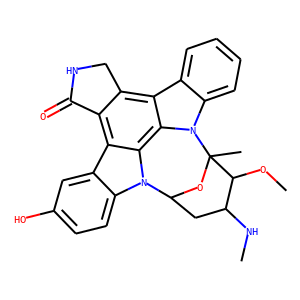

In [ ]:
best_mol = MolFromSmiles("CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6cc(O)ccc6n2c5c31)C(=O)NC4")
Draw.MolToImage(best_mol)

The drug with the highest binding affinity is CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6cc(O)ccc6n2c5c31)C(=O)NC4. And the affinity of this drug to the COVID-19 protease is $14.24049$



### Prediction by the CNN Model

In [ ]:
num_train, num_drugs = rit_ecfp.shape
num_prot = protease_tr.shape[1]
rit_ecfp = rit_ecfp.reshape((num_train, num_drugs, 1))
protease_tr_reshape = protease_tr.reshape((num_train, num_prot, 1))
print(rit_ecfp.shape, protease_tr_reshape.shape)

(1, 1024, 1) (1, 1000, 1)


In [ ]:
path = './drive/MyDrive/Colab Notebooks/data_Drug_target_binding_affinity/cnn_model'
model = tf.keras.models.load_model(path)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_3_input (InputLayer)     [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_4_input (InputLayer)     [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 1022, 16)     64          conv1d_3_input[0][0]             
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 998, 16)      64          conv1d_4_input[0][0]             
____________________________________________________________________________________________

In [ ]:
target = model.predict([rit_ecfp, protease_tr_reshape])[0][0]
print(target)

12.476215


In [ ]:
pred_drug = ritonavior
smileToMol = lambda x: MolFromSmiles(x)
featurizer = dc.feat.CircularFingerprint(size=1024)
for drug in drugs:
  drug_smiles = np.array([Chem.MolToSmiles(Chem.MolFromSmiles(drug),isomericSmiles=True)])
  drug_mol = list(map(smileToMol, drug_smiles))
  drug_ecfp = featurizer.featurize(drug_mol)
  drug_ecfp = drug_ecfp.reshape((num_train, num_drugs, 1))
  score = model.predict([drug_ecfp, protease_tr_reshape])[0][0]
  if score>target:
    print(drug, score)
    target = score
    pred_drug = drug
print(pred_drug, target)

COc1cc(Nc2ncc([N+](=O)[O-])c(Nc3ccccc3C(N)=O)n2)cc(OC)c1OC 12.898549
Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4cccc(OC(F)(F)F)c4)c3)cc12 13.369903
Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4cccc(Cl)c4)c3)cc12 13.8015175
Cc1[nH]nc2ccc(-c3cncc(OCC(N)Cc4ccc(Cl)c(Cl)c4)c3)cc12 13.81483
Cn1cc(Nc2ncc(Br)c(Nc3ccccc3C(N)=O)n2)cn1 13.887487
CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4 14.350755
COc1cc(O)c2c(c1)C1(OC2=O)C(C)=CC(=O)C1O 14.415564
COc1cc(O)c2c(c1)C(=O)c1cc(C)c(O)cc1C2=O 14.471263
Cc1cc(O)cc2oc(=O)c3c(O)cc(OS(=O)(=O)O)cc3c12 14.578851
COc1cc(O)c2c(=O)oc3cc(O)cc(C)c3c2c1 14.655168
COc1cc(O)c2c(=O)oc3c(O)c(O)cc(C)c3c2c1 14.964367
COc1cc(O)c2c(=O)oc3c(O)c(O)cc(C)c3c2c1 14.964367


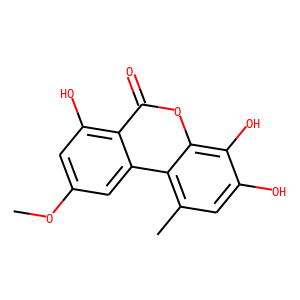

In [ ]:
best_mol = MolFromSmiles("COc1cc(O)c2c(=O)oc3c(O)c(O)cc(C)c3c2c1")
Draw.MolToImage(best_mol)

When using pretrained CNN model, The drug with the highest binding affinity is COc1cc(O)c2c(=O)oc3c(O)c(O)cc(C)c3c2c1. And the affinity of this drug to the COVID-19 protease is $14.96436$. The result is different from the baseline model.